# Detecting Loop from the single runs of the environment using sequence graphs.

In [1]:
import numpy as np
from tqdm import tqdm as tq
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA
# from pyvis.network import Network
from itertools import combinations, chain, product
import matplotlib.pyplot as plt
import networkx as nx
import faiss

import seaborn as sns

In [2]:
small = {
    "freq": 4,
    "loc": "data/small/all_poses_freq_4.npy",
    "desc": "data/small/all_feat.npy",
    # "desc": "data/small/results_1/all_pca_feat.npy",
    "non_gr_seqs": [
        "data/small/results_1/groups/labels_sequence.npy",
        "data/small/results_1/groups/avg_pca_seq_labels_sequence.npy",
    ],
    "seqs": [
        "data/small/results_1/groups/r18l4_seqvlad_seq_labels_sequence.npy",
        "data/small/results_1/groups/r18l3_gem_cat_seq_labels_sequence.npy",
    ],
    "grp_rep": [
        "seq_desc/r18l4_seqvlad_feature@5/small_features.npy",
        "seq_desc/r19_gem_cat_feature@5/small_features.npy",
    ]
}

In [3]:
qsmall = {
    "freq": 3,
    "loc": "data/qsmall/all_poses_freq_3.npy",
    "desc": "data/qsmall/all_feat.npy",
    # "desc": "data/qsmall/results/all_pca_feat.npy",
    "non_gr_seqs": [
        "data/qsmall/results/groups/labels_sequence.npy",
        "data/qsmall/results/groups/avg_pca_seq_labels_sequence.npy",
    ],
    "seqs": [
        "data/qsmall/results/groups/r18l4_seqvlad_seq_labels_sequence.npy",
        "data/qsmall/results/groups/r18l3_gem_cat_seq_labels_sequence.npy",
    ],
    "grp_rep": [
        "seq_desc/r18l4_seqvlad_feature@5/qsmall_features.npy",
        "seq_desc/r19_gem_cat_feature@5/qsmall_features.npy",
    ]
}

In [4]:
rsmall = {
    "freq": 3,
    "loc": "data/rsmall/all_poses_freq_3.npy",
    "desc": "data/rsmall/all_feat.npy",
    # "desc": "data/rsmall/results/all_pca_feat.npy",
    "non_gr_seqs": [
        "data/rsmall/results/groups/labels_sequence.npy",
        "data/rsmall/results/groups/avg_pca_seq_labels_sequence.npy",
    ],
    "seqs": [
        "data/rsmall/results/groups/r18l4_seqvlad_seq_labels_sequence.npy",
        "data/rsmall/results/groups/r18l3_gem_cat_seq_labels_sequence.npy",
    ],
    "grp_rep": [
        "seq_desc/r18l4_seqvlad_feature@5/rsmall_features.npy",
        "seq_desc/r19_gem_cat_feature@5/rsmall_features.npy",
    ]
}

In [3]:
def perform_kmeans(data, k):
	model = KMeans(n_clusters=k, init="k-means++",  random_state=42) # random_state=42 does something, I'm not able to understand
	return model.fit(data)

def kmean_score_list(data, k_list=range(2,120)):
	silhouette_scores = []
	elbow_scores = []
	for k in k_list:
		model = perform_kmeans(data, k)  					 # applied kmeans clustering fitted estimator
		es = model.inertia_ 								 # calculate elbow method score
		ss = metrics.silhouette_score(data, model.labels_)   # calculate silhouette_score
		silhouette_scores += [ss]
		elbow_scores += [es]
	return k_list, silhouette_scores, elbow_scores

def top_rank_cluster_number(k_list, silhouette_scores, elbow_scores):
	elbow = KneeLocator(k_list, elbow_scores, curve='convex', direction='decreasing').knee
	silhouette = np.argmax(silhouette_scores) + 1
	return elbow, silhouette

def compute_cluster_number_frequency(data, iterations=100, k_list=range(2,120)):
	k_freq = np.zeros((2,len(k_list)+1))
	for i in tq(range(iterations)):
		_, silhouette_scores, elbow_scores = kmean_score_list(data, k_list)
		print("Elbow score = ", elbow_scores)
		print("Silhouette score = ", silhouette_scores)
		elbow_top_rank, silhouette_top_rank = top_rank_cluster_number(k_list, silhouette_scores, elbow_scores)
		k_freq[0][elbow_top_rank] += 1
		k_freq[1][silhouette_top_rank] += 1
	print(k_freq)
	return k_freq[0], k_freq[1]

In [4]:
def compute_pca(feature, rel_thresh=0.01):
	pd_feature = pd.DataFrame(feature)

	for col in pd_feature.columns:
		pd_feature[col] = (pd_feature[col] - pd_feature[col].mean() ) / pd_feature[col].std()
	
	previous_percent = 0
	current_percent = 0
	relative_tolerance = rel_thresh
	best_components = -1
	for i in range(1,min(len(feature),len(pd_feature.columns))):
		pca = PCA(n_components=i)
		pca_result = pca.fit_transform(pd_feature)
		current_percent = np.sum(pca.explained_variance_ratio_)
		if current_percent-previous_percent>relative_tolerance:
			previous_percent = current_percent
			best_components = i
		else:
			break
	print("Relevant top", best_components, " pca-components! They got Cumulative variance = ", 100*current_percent)
	print("Variation per principal component:\n",pca.explained_variance_ratio_)
	return pca_result, pca

In [5]:
class SeqGraph:
	"""
	class to build a graph for the sequence as node
	and edges weight will be similarity between the
	sequence representatives.
	"""
	def __init__(self, seq_id, seq_label,seq_color, seq_rep):
		self.seq_id = seq_id
		self.seq_rep = seq_rep
		self.seq_label = seq_label
		self.seq_color = seq_color
		self.net = None
		self.possible_metric = ["EXP_DOT", "NEG_EXP_ED", "DOT", "NEG_ED"]
	
	def _get_similitude(self,A,B,metric):
		assert metric in self.possible_metric
		if metric=="DOT":
			dt = A*B
			dt = np.sum(dt, axis=1)
			dt = (dt)/(np.linalg.norm(A, axis=1)*np.linalg.norm(B, axis=1))
			return dt
		elif metric=="NEG_ED":
			dt = (A-B)**2
			dt = np.sum(dt,axis=1)
			dt = -np.sqrt(dt)
			return dt
		elif metric=="NEG_EXP_ED":
			dt = (A-B)**2
			dt = np.sum(dt,axis=1)
			dt = -np.sqrt(dt)
			return np.exp(dt)
		elif metric=="EXP_DOT":
			dt = A*B
			dt = np.sum(dt, axis=1)
			dt = (dt)/(np.linalg.norm(A, axis=1)*np.linalg.norm(B, axis=1))
			return np.exp(dt)
		else:
			raise ValueError("Unknown Metric for computing similitudes.")
	
	def _get_edges(self, metric, ts):
		id_pairs = list(combinations(self.seq_id, 2))
		id_pairs = list(chain(*id_pairs))
		id1 = np.array(id_pairs[0::2])
		id2 = np.array(id_pairs[1::2])
		ds_pairs = list(combinations(self.seq_rep, 2))
		ds_pairs = list(chain(*ds_pairs))
		ds1 = np.array(ds_pairs[0::2])
		ds2 = np.array(ds_pairs[1::2])
		similitude = self._get_similitude(ds1,ds2, metric)
		id_similitude = np.vstack((id1,id2))
		id_similitude = np.vstack((id_similitude,similitude))
		ordey_by_similitude = lambda x: -x[-1]
		id_similitude = np.array(sorted(id_similitude.T, key=ordey_by_similitude))
		# pair_len = int(len(id_similitude)*edge_percent)
		pair_idx = id_similitude[:,-1] >= ts
		# print(id_similitude)
		# return np.array(id_similitude[:pair_len])
		return np.array(id_similitude[pair_idx])
		
	
	def build_graph(self, ts=1,metric="DOT"):
		G = nx.Graph()
		G.add_nodes_from(
			self.seq_id,
			# label=self.seq_label,
			title=self.seq_label,
			color= self.seq_color
		)
		edges = self._get_edges(metric, ts)
		edges = list(map(tuple, edges))
		G.add_weighted_edges_from(edges)
		self.net = G
		return self.net

In [6]:
class LoopDetection():
	def __init__(self, runs, tg=1, ts=1, model="seqvlad", seq_len=5):
		self.runs=runs
		self.tg=tg
		self.ts=ts
		self.all_locs = []
		self.all_desc = []
		self.all_env_loc_count = []
		self.all_seqs_rep = []
		self.all_run_seq_count = []
		self.all_label_seqs = []
		self.possible_models = ["seqvlad", "r18l3_gem_cat"]
		assert model in self.possible_models
		self.model=model
		self.seq_pca_mat = None
		self.all_pca_seqs_rep = None
		self.seq_graph = None
		self.loop_pairs = None
		self.possible_metric = ["EXP_DOT", "NEG_EXP_ED", "DOT", "NEG_ED"]
		self.seq_len=seq_len
	
	def init_raw_info(self):
		for run in self.runs:
			pos = np.load(run["loc"])
			des = np.load(run["desc"])
			self.all_locs.extend(pos)
			self.all_desc.extend(des)
			self.all_env_loc_count.append(len(pos))
		self.all_locs = np.asarray(self.all_locs)
		self.all_desc = np.asarray(self.all_desc)
	
	def init_seq_info(self):
		model_id = self.possible_models.index(self.model)
		for run in self.runs:
			label_seq = np.load(run["non_gr_seqs"][0],allow_pickle=True)
			group_rep = np.load(run["grp_rep"][model_id],allow_pickle=True).item()
			curr_seqr = []
			curr_label_seq = []
			for label_idx, label in enumerate(label_seq):
				for seq_idx, seq in enumerate(label):
					[s,e] = seq
					seq_id = str(label_idx)+"_"+str(seq_idx)
					if group_rep.get('test'+str(seq_id)) is not None:
						curr_seqr.append(group_rep["test"+seq_id])
						curr_label_seq.append(seq)
			self.all_run_seq_count.append(len(curr_seqr))
			self.all_label_seqs.extend(curr_label_seq)
			self.all_seqs_rep.extend(curr_seqr)
		self.all_seqs_rep = np.asarray(self.all_seqs_rep)
		self.all_label_seqs = np.asarray(self.all_label_seqs)
	
	def reduce_seq_rep(self, X=None):
		if X is None:
			X = self.all_seqs_rep
		_,self.seq_pca_mat = compute_pca(X, 0.001)
		self.all_pca_seqs_rep = self.seq_pca_mat.transform(self.all_seqs_rep)
	
	def _initialise_seq_graph(self, ts):
		seq_id = np.array(range(len(self.all_label_seqs)))
		seq_color = np.array([ i+1 for i in range(len(self.all_run_seq_count)) for _ in range(self.all_run_seq_count[i])  ])
		seq_label = np.array([ 
			str(seq_color[i])+"["+str(self.all_label_seqs[i][0])+":"+str(str(self.all_label_seqs[i][1]))+"]" for i in range(len(self.all_label_seqs))])
		self.seq_graph = SeqGraph(seq_id, seq_color, seq_label, self.all_pca_seqs_rep)
		self.seq_net = self.seq_graph.build_graph(ts)
	
	def visualise_seq_network(self):
		fig = plt.figure(1, figsize=(10, 8))
		# nx.draw(self.seq_net, with_labels=True)
		edges = self.seq_net.edges.data()
		for edge in edges:
			(seq_id1, seq_id2, _) = edge
			pose1_id = self.all_label_seqs[int(seq_id1)][0]
			pose2_id = self.all_label_seqs[int(seq_id2)][0]
			pose1 = self.all_locs[pose1_id]
			pose2 = self.all_locs[pose2_id]
			plt.plot([pose1[0],pose2[0]], [pose1[1], pose2[1]], 'ro',linestyle="--", alpha=0.2)
			plt.scatter([pose1[0],pose2[0]], [pose1[1], pose2[1]], s=60, c='b',marker='o',alpha=1)
			plt.text(pose1[0], pose1[1], str(int(seq_id1)))
			plt.text(pose2[0], pose2[1], str(int(seq_id2)))
		X = self.all_locs[:,0]
		Y = self.all_locs[:,1]
		plt.plot(X,Y, c='g')
		plt.show()

	def _get_gd_similitude(self,A,B,metric):
		assert metric in self.possible_metric
		if metric=="DOT":
			dt = A*B
			dt = np.sum(dt, axis=1)
			dt = (dt)/(np.linalg.norm(A,axis=1)*np.linalg.norm(B,axis=1))
			return dt
		elif metric=="NEG_ED":
			dt = (A-B)**2
			dt = np.sum(dt,axis=1)
			dt = -np.sqrt(dt)
			return dt
		elif metric=="NEG_EXP_ED":
			dt = (A-B)**2
			dt = np.sum(dt,axis=1)
			dt = -np.sqrt(dt)
			return np.exp(dt)
		elif metric=="EXP_DOT":
			dt = A*B
			dt = np.sum(dt, axis=1)
			dt = (dt)/(np.linalg.norm(A,axis=1)*np.linalg.norm(B,axis=1))
			return np.exp(dt)
		else:
			raise ValueError("Unknown Metric for computing similitudes.")
				
	def _seq_seq_matching(self, seq_id1, seq_id2, metric, tg):
		label_seq1 = self.all_label_seqs[int(seq_id1)]
		label_seq2 = self.all_label_seqs[int(seq_id2)]
		# if label_seq1[1]-label_seq1[0] + 1 < self.seq_len:
		# 	print("seq1 is small")
		# 	return []
		# if label_seq2[1]-label_seq2[0] + 1 < self.seq_len:
		# 	print("seq2 is small")
		# 	return []
		img_pairs = product(list(range(label_seq1[0], label_seq1[1]+1)), list(range(label_seq2[0], label_seq2[1]+1)))
		img_pairs = list(chain(*img_pairs))
		imsg1 = np.array(img_pairs[0::2])
		imsg2 = np.array(img_pairs[1::2])
		ds1 = self.all_desc[imsg1]
		ds2 = self.all_desc[imsg2]
		similitude = self._get_gd_similitude(ds1,ds2, metric)
		id_similitude = np.vstack((imsg1, imsg2))
		id_similitude = np.vstack((id_similitude,similitude))
		id_similitude = id_similitude.T
		pair_idx = id_similitude[:,-1]>=tg
		return id_similitude[pair_idx]

	# def _remove_temporarily_close_lp(self, lp_similitude, th=5):
	# 	new_lp = []
	# 	for lp in lp_similitude:
	# 		if abs(lp[0]-lp[1])<=th:
	# 			continue
	# 		else:
	# 			new_lp.append(lp)
	# 	return new_lp
	
	def compute_loop_pairs(self, seq_matching_metric="DOT", ts=None, tg=None):
		if ts is None:
			ts = self.ts
		if tg is None:
			tg=self.tg
		self.loop_pairs = []
		self._initialise_seq_graph(ts)
		edges = self.seq_net.edges.data()
		for edge in edges:
			(seq_id1, seq_id2, _) = edge
			lp_similitude = self._seq_seq_matching(seq_id1, seq_id2, seq_matching_metric, tg)
			self.loop_pairs.extend(lp_similitude)
			# self.loop_pairs.extend(self._remove_temporarily_close_lp(lp_similitude))
		return self.loop_pairs


# Evaluate the LPs

In [7]:
def get_precision(lp, loc, r=5):
	tp = 0
	dt = {}
	for (a,b,s) in lp:
		x = int(a)
		y = int(b)
		lx = loc[x]
		ly = loc[y]
		if str(a)+"-"+str(b) in dt:
			continue
		elif str(b)+"-"+str(a) in dt:
			continue
		else:
			dt[str(a)+"-"+str(b)]=1
		if np.sqrt(np.sum((lx-ly)**2))<=r:
			tp+=1
	if len(lp)==0:
		return 0
	return tp/len(lp)

def get_recall(lp,loc, SRP_idx,r=5):
	all_p = 0
	loc_p = list(combinations(loc[SRP_idx], 2))
	for p in loc_p:
		lx = p[0]
		ly = p[1]
		if np.sqrt(np.sum((lx-ly)**2))<=r:
			all_p+=1
	tp = 0
	dt = {}
	for (a,b,s) in lp:
		x = int(a)
		y = int(b)
		if str(a)+"-"+str(b) in dt:
			continue
		elif str(b)+"-"+str(a) in dt:
			continue
		else:
			dt[str(a)+"-"+str(b)]=1
		lx = loc[x]
		ly = loc[y]
		if np.sqrt(np.sum((lx-ly)**2))<=r:
			tp+=1
	return tp/all_p

# Comparing sequence based system LPs vs GD based system LPs

In [8]:
def compute_gd_lp(run, tg=1, exclude_previous_frame=5, metric="DOT", pca=False):
	loc = np.load(run["loc"])
	des = np.load(run["desc"]).astype('float32')
	if pca:
		des, _= compute_pca(des, 0.001)
	lp = []
	for i in range(len(loc)):
		ref_set_idx = set(range(i))
		ref_set_idx = list(ref_set_idx - set(range(i-exclude_previous_frame,i)))
		# ref_set_idx = list(ref_set_idx - set(range(i-exclude_previous_frame,i+exclude_previous_frame+1)))
		if len(ref_set_idx)<=0:
			continue
		ref_set = des[ref_set_idx]
		query = des[i]
		if metric=="DOT":
			dt = lambda x,y: np.sum(x*y)/(np.linalg.norm(x)*np.linalg.norm(x))
			curr_lp = [ [i,rd_idx, dt(query, rd)] for rd_idx,rd in enumerate(ref_set)  if dt(query, rd)>tg ]
		else:
			raise ValueError("No new metric defined")
		# faiss_index = faiss.IndexFlatL2(len(ref_set[0]))
		# faiss_index.add(ref_set.copy(order='C'))
		# distances, predictions = faiss_index.search(np.array([query]), len(ref_set_idx))
		# curr_lp = [ [i,ref_set_idx[predictions[0][j]], distances[0][j]] for j in range(len(distances[0])) if distances[0][j]>tg ]
		lp.extend(curr_lp)
	lp = np.array(lp)
	# uniqueLP, idx_start, idx_count = np.unique(np.sort(lp[:,:2],axis=1), axis=0, return_index=True, return_counts=True)
	return lp
	# return lp[idx_start]

In [9]:
small_ld_r18l3_gem_cat = LoopDetection([small], model="r18l3_gem_cat")
small_ld_r18l3_gem_cat.init_raw_info()
small_ld_r18l3_gem_cat.init_seq_info()
small_ld_r18l3_gem_cat.reduce_seq_rep()
# qsmall_ld_r18l3_gem_cat = LoopDetection([qsmall], model="r18l3_gem_cat")
# qsmall_ld_r18l3_gem_cat.init_raw_info()
# qsmall_ld_r18l3_gem_cat.init_seq_info()
# qsmall_ld_r18l3_gem_cat.reduce_seq_rep()
# rsmall_ld_r18l3_gem_cat = LoopDetection([rsmall], model="r18l3_gem_cat")
# rsmall_ld_r18l3_gem_cat.init_raw_info()
# rsmall_ld_r18l3_gem_cat.init_seq_info()
# rsmall_ld_r18l3_gem_cat.reduce_seq_rep()

Relevant top 26  pca-components! They got Cumulative variance =  100.00001192092896
Variation per principal component:
 [0.17002377 0.12862125 0.08042457 0.06336631 0.05394106 0.0484882
 0.03952897 0.03405661 0.03243835 0.03070126 0.02955544 0.02732764
 0.02612267 0.02380461 0.02274263 0.0212653  0.02036336 0.01989546
 0.01911357 0.01866817 0.01734428 0.01608055 0.01520673 0.01441811
 0.01336615 0.01313503]


In [10]:
small_ld_seqvlad = LoopDetection([small])
small_ld_seqvlad.init_raw_info()
small_ld_seqvlad.init_seq_info()
small_ld_seqvlad.reduce_seq_rep()
# qsmall_ld_seqvlad = LoopDetection([qsmall])
# qsmall_ld_seqvlad.init_raw_info()
# qsmall_ld_seqvlad.init_seq_info()
# qsmall_ld_seqvlad.reduce_seq_rep()
# rsmall_ld_seqvlad = LoopDetection([rsmall])
# rsmall_ld_seqvlad.init_raw_info()
# rsmall_ld_seqvlad.init_seq_info()
# rsmall_ld_seqvlad.reduce_seq_rep()

Relevant top 26  pca-components! They got Cumulative variance =  100.0
Variation per principal component:
 [0.31610724 0.17893767 0.0914733  0.06708553 0.05310537 0.04012885
 0.03865136 0.02981609 0.02280902 0.0208463  0.01864368 0.01551177
 0.01375978 0.01291955 0.01243622 0.00986859 0.0089516  0.00852189
 0.00736017 0.00647514 0.00569254 0.00517122 0.00480253 0.00419918
 0.00365099 0.00307439]


# Fix GT-radius, check values recall of combinations of tg, ts

In [11]:
def PR_tg_ts_combinations(tg_list, ts_list,small_ld, small, rad=5):
	SRP = get_restricted_poses(small_ld)
	SRP_idx = np.array(SRP)!=-1
	P = []
	R = []
	X,Y=[],[]
	for tg in tg_list:
		GDS_LP = compute_gd_lp(small, tg=tg)
		gds_LP = []
		# print("GDS_LP len = ",len(GDS_LP))
		for l in GDS_LP:
			if SRP[int(l[0])]!=-1 and SRP[int(l[1])]!=-1:
				continue
			else:
				gds_LP.append(l)
		# print("gds_LP len = ",len(gds_LP))
		gds_pr = get_precision(gds_LP, small_ld.all_locs, rad)
		gds_rc = get_recall(gds_LP, small_ld.all_locs, SRP_idx, rad)
		for ts in tq(ts_list):
			SEQ_LP = small_ld.compute_loop_pairs(ts=ts,tg=tg)
			seq_LP = []
			for l in SEQ_LP:
				if SRP[int(l[0])]!=-1 and SRP[int(l[1])]!=-1:
					continue
				else:
					seq_LP.append(l)
			# print("ts = ",ts, " tg = ", tg, " seq_LP = ", len(seq_LP))
			seq_pr = get_precision(seq_LP, small_ld.all_locs, rad)
			seq_rc = get_recall(seq_LP, small_ld.all_locs, SRP_idx, rad)
			P.append([seq_pr, gds_pr])
			R.append([seq_rc, gds_rc])
			X.append(tg)
			Y.append(ts)
	P = np.array(P)
	R = np.array(R)
	return X,Y,P,R


In [12]:
def get_restricted_poses(small_ld):
	custom_labl = [-1]*len(small_ld.all_locs)
	label_seq = np.load(small_ld.runs[0]["non_gr_seqs"][0],allow_pickle=True)
	curr_sL = []
	curr_run_seq = []
	for label_idx, label in enumerate(label_seq):
		for seq_idx, seq in enumerate(label):
			[s,e] = seq
			if e-s+1<=5:
				curr_sL.append(-1)
			else:
				curr_sL.append(label_idx)
			curr_run_seq.append(seq)
	# print(len(curr_sL), len(curr_run_seq))
	# print("curr_SL = ",curr_sL, " curr_run_seq = ",curr_run_seq)
	for id,seq in enumerate(curr_run_seq):
		[s,e] = seq
		x = [curr_sL[id]]*(e-s+1)
		custom_labl[s:+e+1]=x
	return custom_labl

In [13]:
# small_restricted_poses1 = get_restricted_poses(small_ld_seqvlad)
# small_restricted_poses2 = get_restricted_poses(small_ld_r18l3_gem_cat)
# qsmall_restricted_poses1 = get_restricted_poses(qsmall_ld_seqvlad)
# qsmall_restricted_poses2 = get_restricted_poses(qsmall_ld_r18l3_gem_cat)
# rsmall_restricted_poses1 = get_restricted_poses(rsmall_ld_seqvlad)
# rsmall_restricted_poses2 = get_restricted_poses(rsmall_ld_r18l3_gem_cat)

In [14]:
# TS = np.arange(0.1, 0.8, 0.04)
TG = np.arange(0.2, 0.8, 0.04)
TS = [0.7]
print("TG list = ",TG)
print("TS list = ",TS)

TG list =  [0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52 0.56 0.6  0.64 0.68 0.72
 0.76 0.8 ]
TS list =  [0.7]


In [15]:
X,Y,P,R= PR_tg_ts_combinations(TG, TS, small_ld_seqvlad, small)

100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


In [16]:
Xc,Yc,Pc,Rc= PR_tg_ts_combinations(TG, TS, small_ld_r18l3_gem_cat, small)

100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


In [43]:
qX,qY,qP,qR= PR_tg_ts_combinations(TG, TS, qsmall_ld_seqvlad, qsmall)
qXc,qYc,qPc,qRc= PR_tg_ts_combinations(TG, TS, qsmall_ld_r18l3_gem_cat, qsmall)

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


In [44]:
rX,rY,rP,rR= PR_tg_ts_combinations(TG, TS, rsmall_ld_seqvlad, rsmall)
rXc,rYc,rPc,rRc= PR_tg_ts_combinations(TG, TS, rsmall_ld_r18l3_gem_cat, rsmall)

100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


In [45]:
s=0
t=len(P)
# print(len(P), len(rP), len(qP))
print("small Diff. Precision = ", (np.sum(P[s:t,0])-np.sum(P[s:t,1]))/len(P))
print("small Diff. Recall = ", (np.sum(R[s:t,0])-np.sum(R[s:t,1]))/len(R))
print("small Diff. Precision = ", np.sum(P[:,0])/len(P),(np.sum(P[:,1]))/len(P), np.sum(Pc[:,0])/len(Pc),(np.sum(Pc[:,1]))/len(Pc))
print("small Diff. Recall = ", np.sum(R[:,0])/len(R),(np.sum(R[:,1]))/len(Rc), np.sum(Rc[:,0])/len(Rc),(np.sum(Rc[:,1]))/len(Rc))

small Diff. Precision =  0.09046660452361593
small Diff. Recall =  -0.1299786745406824
small Diff. Precision =  0.50990927600396 0.41944267148034403 0.4848721322069209 0.41944267148034403
small Diff. Recall =  0.0563238188976378 0.1863024934383202 0.05843996062992126 0.1863024934383202


In [46]:

print("rsmall Diff. Precision = ", (np.sum(rP[s:t,0])-np.sum(rP[s:t,1]))/len(rP))
print("rsmall Diff. Recall = ",( np.sum(rR[s:t,0])-np.sum(rR[s:t,1]))/len(rP))
print("rsmall Diff. Precision = ", np.sum(rP[:,0])/len(rP),(np.sum(rP[:,1]))/len(rP), np.sum(rPc[:,0])/len(rPc),(np.sum(rPc[:,1]))/len(rPc))
print("rsmall Diff. Recall = ", np.sum(rR[:,0])/len(rP),(np.sum(rR[:,1]))/len(rP), np.sum(rRc[:,0])/len(rPc),(np.sum(rRc[:,1]))/len(rPc))

rsmall Diff. Precision =  -0.08785401571602841
rsmall Diff. Recall =  -0.83717277486911
rsmall Diff. Precision =  0.30003100655995235 0.38788502227598076 0.2619369348576387 0.38788502227598076
rsmall Diff. Recall =  0.1850785340314136 1.0222513089005236 0.18399869109947642 1.0222513089005236


In [47]:

print("qsmall Diff. Precision = ", (np.sum(qP[s:t,0])-np.sum(qP[s:t,1]))/len(qP))
print("qsmall Diff. Recall = ", (np.sum(qR[s:t,0])-np.sum(qR[s:t,1]))/len(qR))
print("qsmall Diff. Precision = ", np.sum(qP[:,0])/len(qP),(np.sum(qP[:,1]))/len(qP), np.sum(qPc[:,0])/len(qPc),(np.sum(qPc[:,1]))/len(qPc))
print("qsmall Diff. Recall = ", np.sum(qR[:,0])/len(qP),(np.sum(qR[:,1]))/len(qR), np.sum(qRc[:,0])/len(qPc),(np.sum(qRc[:,1]))/len(qRc))

qsmall Diff. Precision =  0.1280395474382623
qsmall Diff. Recall =  -0.09725381865453364
qsmall Diff. Precision =  0.6581940409370091 0.5301544934987468 0.6340134701260771 0.5301544934987468
qsmall Diff. Recall =  0.09547990466904993 0.19273372332358357 0.10359116022099447 0.19273372332358357


# P-R curve

In [17]:
SP = np.array([P[:,0],P[:,1],Pc[:,0]]).T
SR = np.array([R[:,0],R[:,1],Rc[:,0]]).T
# qSP = np.array([qP[:,0],qP[:,1],qPc[:,0]]).T
# qSR = np.array([qR[:,0],qR[:,1],qRc[:,0]]).T
# rSP = np.array([rP[:,0],rP[:,1],rPc[:,0]]).T
# rSR = np.array([rR[:,0],rR[:,1],rRc[:,0]]).T

In [33]:
def plot_pr_curve_for_our_naive_bow(P,R, title):
    C1 = np.array([R[0],P[0]]).T
    C2 = np.array([R[1],P[1]]).T
    C3 = np.array([R[2],P[2]]).T
    C4 = np.array([R[3],P[3]]).T
    C5 = np.array([R[4],P[4]]).T
    sC1 = C1[C1[:,0].argsort()]
    sC2 = C2[C2[:,0].argsort()]
    sC3 = C3[C3[:,0].argsort()]
    sC4 = C4[C4[:,0].argsort()]
    sC5 = C5[C5[:,0].argsort()]

    sC1 = sC1[::-1]
    sC2 = sC2[::-1]
    sC3 = sC3[::-1]
    sC4 = sC4[::-1]
    sC5 = sC5[::-1]
    # print("C1 = ",C1)
    # print("C2 = ",C2)
    # print("sC1 = ",len(sC1))
    # print("sC2 = ",len(sC2))

    S1 = [sC1[0]]
    for i in range(1,len(sC1)):
        if sC1[i-1][0]==sC1[i][0]:
            continue
        else:
            S1.append(sC1[i])
    
    S2 = [sC2[0]]
    for i in range(1,len(sC2)):
        if sC2[i-1][0]==sC2[i][0]:
            continue
        else:
            S2.append(sC2[i])
    
    S3 = [sC3[0]]
    for i in range(1,len(sC3)):
        if sC3[i-1][0]==sC3[i][0]:
            continue
        else:
            S3.append(sC3[i])
    
    S4 = [sC4[0]]
    for i in range(1,len(sC4)):
        if sC4[i-1][0]==sC4[i][0]:
            continue
        else:
            S4.append(sC4[i])

    
    S5 = [sC5[0]]
    for i in range(1,len(sC5)):
        if sC5[i-1][0]==sC5[i][0]:
            continue
        else:
            S5.append(sC5[i])


    fig = plt.figure(figsize=(10,7))
    plt.rcParams.update({'font.size': 17})
    plt.plot(np.array(S1)[:,0], np.array(S1)[:,1], c='g', label="Our system(Variable Length Sequence)")
    plt.plot(np.array(S2)[:,0], np.array(S2)[:,1], c='r', label="ResNet+GeM")
    plt.plot(np.array(S3)[:,0], np.array(S3)[:,1], c='b', label="DBoW2")
    plt.plot(np.array(S4)[:,0], np.array(S4)[:,1], c='y', label="our system(Fixed Length Sequence)")
    plt.plot(np.array(S5)[:,0], np.array(S5)[:,1], c='o', label="ResNet+GeM+Cat(Fixed Length Sequence)")
    plt.legend(["Our system Loop Pairs", "ResNet+GeM Loop Pairs","DBoW2 Loop Pairs", "ResNet+GeM+Cat(Fixed Length Sequence)" ], fontsize="15")
    plt.legend(["our system(Variable Length Sequence)", "ResNet+GeM","DBoW2", "our system(Fixed Length Sequence)" , "ResNet+GeM+Cat(Fixed Length Sequence)"], fontsize="20")
    # plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()


In [22]:
def plot_pr_curve(P,R, title):
    C1 = np.array([R[:,0],P[:,0]]).T
    C2 = np.array([R[:,1],P[:,1]]).T
    C3 = np.array([R[:,2],P[:,2]]).T
    sC1 = C1[C1[:,0].argsort()]
    sC2 = C2[C2[:,0].argsort()]
    sC3 = C3[C3[:,0].argsort()]

    sC1 = sC1[::-1]
    sC2 = sC2[::-1]
    sC3 = sC3[::-1]

    S1 = []
    for i in range(1,len(sC1)):
        if sC1[i-1][0]==sC1[i][0]:
            continue
        else:
            S1.append(sC1[i-1])

    S2 = []
    for i in range(1,len(sC2)):
        if sC2[i-1][0]==sC2[i][0]:
            continue
        else:
            S2.append(sC2[i-1])

    S3 = []
    for i in range(1,len(sC3)):
        if sC3[i-1][0]==sC3[i][0]:
            continue
        else:
            S3.append(sC3[i-1])

    # for s in S1:
    #     print("S1 = ",s)
    # for s in S2:
    #    print("S2 = ",s)
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(10,7))
    plt.plot(np.array(S1)[:,0], np.array(S1)[:,1], c='g', label="seqvlad-SD with ResNet+Gem-GD")
    plt.plot(np.array(S2)[:,0], np.array(S2)[:,1], c='r', label="ResNet+GeM-GD")
    plt.plot(np.array(S3)[:,0], np.array(S3)[:,1], c='b', label="R18l3-gem-cat-SD with ResNet+Gem-GD")
    plt.legend(["seqvlad-SD with ResNet+Gem-GD","ResNet+GeM-GD", "R18l3-gem-cat-SD with ResNet+Gem-GD" ],)
    # plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

In [34]:
tsFP = np.load("PR_values/pr_rsmall_our_naive_bow_ourbow.npy", allow_pickle=True)
tsFR = np.load("PR_values/rc_rsmall_our_naive_bow_ourbow.npy", allow_pickle=True)
tsFP[3]=P[:,0]
tsFR[3]=R[:,0]
tsFP = np.hstack((tsFPc[:,0]))
tsFR = np.hstack((tsFRc[:,0]))
plot_pr_curve_for_our_naive_bow(tsFP, tsFR, "small-dataset(variable length sequences)")

AttributeError: 'numpy.ndarray' object has no attribute 'append'

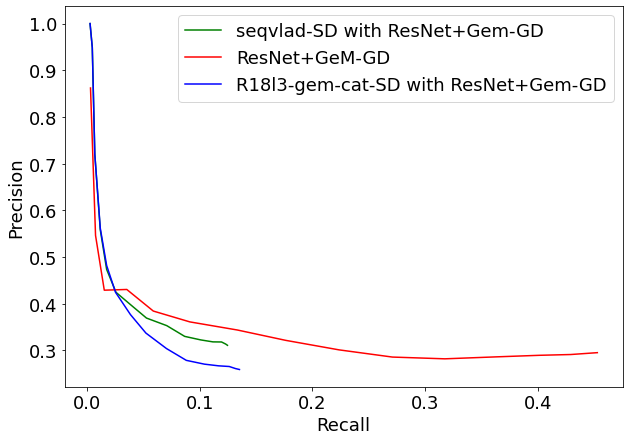

In [23]:
plot_pr_curve(SP,SR, "small-run(sequence length = 5, ts = 0.9)")
# plot_pr_curve(qSP,qSR, "qsmall-run(sequence length = 5, ts = 0.9)")
# plot_pr_curve(rSP,rSR, "rsmall-run(sequence length = 5, ts = 0.9)")

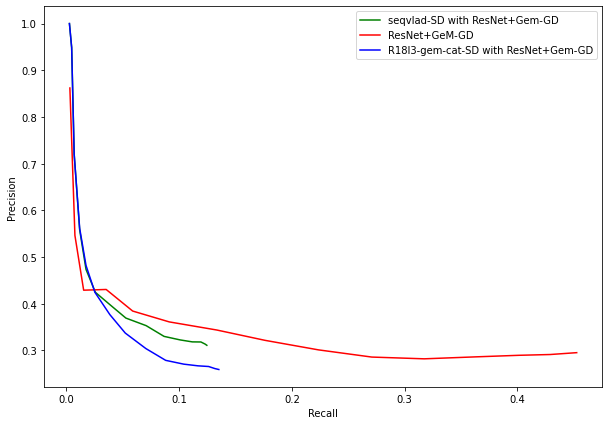

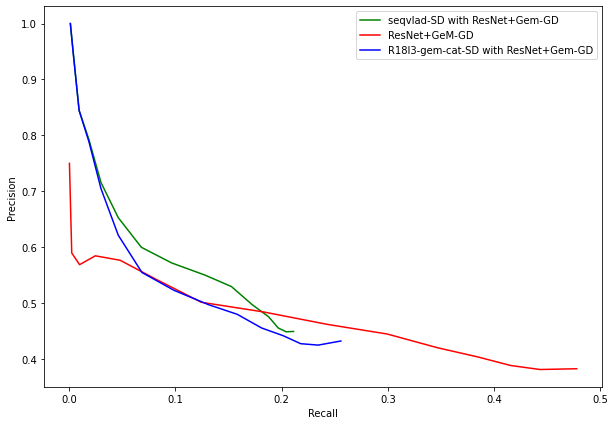

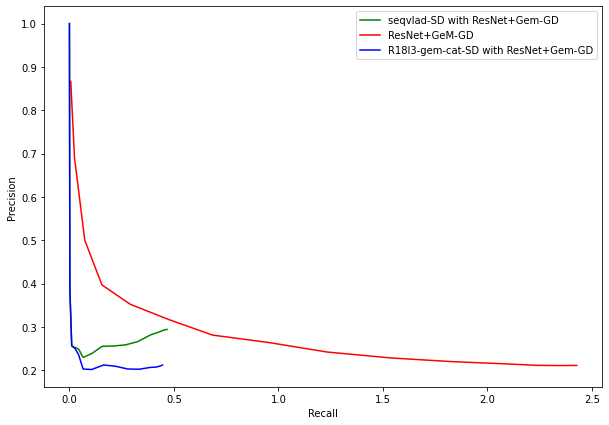

In [50]:
plot_pr_curve(SP,SR, "small-run(sequence length = 5, ts = 0.7)")
plot_pr_curve(qSP,qSR, "qsmall-run(sequence length = 5, ts = 0.7)")
plot_pr_curve(rSP,rSR, "rsmall-run(sequence length = 5, ts = 0.7)")

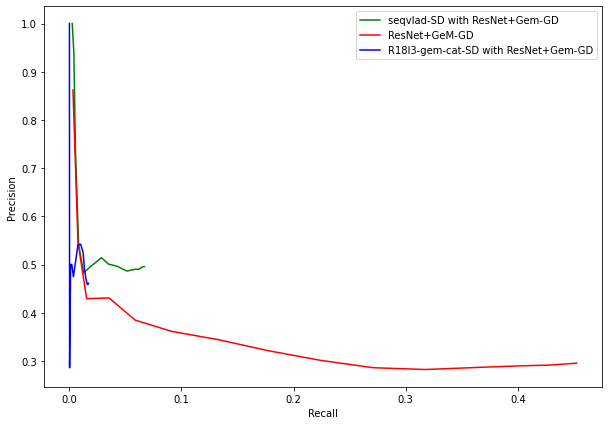

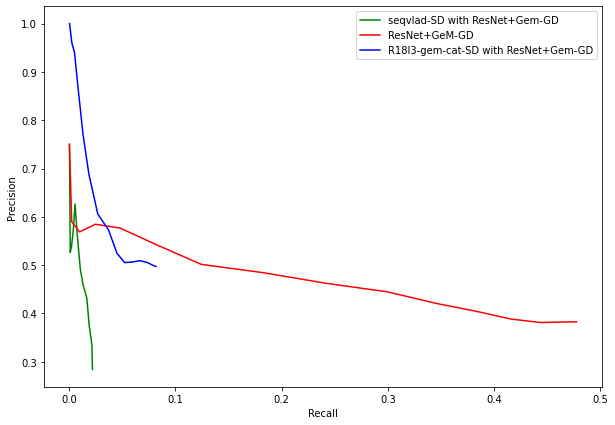

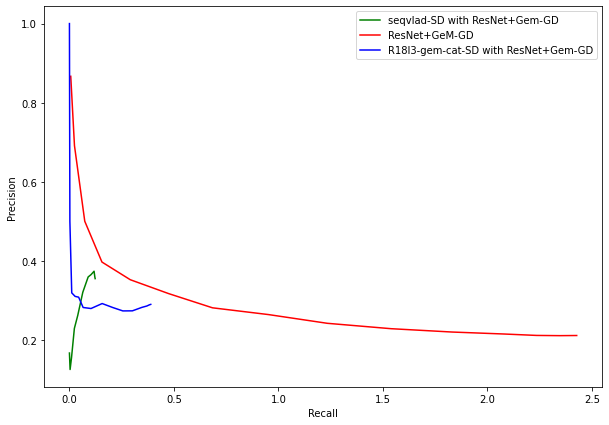

In [31]:
plot_pr_curve(SP,SR, "small-run(sequence length = 5, ts = 0.5)")
plot_pr_curve(qSP,qSR, "qsmall-run(sequence length = 5, ts = 0.5)")
plot_pr_curve(rSP,rSR, "rsmall-run(sequence length = 5, ts = 0.5)")
